# Zero-Deforestation challenge - Image Classification

## 1) Import Modules

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

import tensorflow as tf
import tensorflow_addons as tfa

import os
import numpy as np
import pandas as pd
from PIL import Image

## 2) Download and import datasets

In [3]:
!curl -O "https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train.csv"
!curl -O "https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/test.csv"
!curl -O "https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train_test_data.zip"
!unzip -q "train_test_data.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127k  100  127k    0     0   422k      0 --:--:-- --:--:-- --:--:--  423k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46610  100 46610    0     0   258k      0 --:--:-- --:--:-- --:--:--  257k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  309M  100  309M    0     0  82.1M      0  0:00:03  0:00:03 --:--:-- 82.1M


In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train['label'] = train['label'].astype(str)

## 3) Pre-propressing Model

In [10]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'train_test_data/train'

In [11]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [12]:
for layer in inception.layers:
    layer.trainable = False

In [13]:
x = Flatten()(inception.output)


In [15]:
# softmax is used for multi-class classification predictions
num_of_classes=train['label'].nunique()
prediction = Dense(num_of_classes, activation='softmax')(x)

In [16]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [17]:
#Summary of the InceptionV3 (Convolutional Neural Network) model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## 4) Training the model

In [18]:
#running the f1 macro metric 

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=[tfa.metrics.F1Score(average='macro',num_classes=num_of_classes)]
)

In [19]:
#pre-processing the images before training 

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        zoom_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [44]:
batch_size = 16
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="example_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="example_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory=None,
x_col="example_path",
y_col=None,
batch_size=batch_size,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224, 224))

Found 1372 validated image filenames belonging to 3 classes.
Found 342 validated image filenames belonging to 3 classes.
Found 635 validated image filenames.


In [21]:
# fit the model
# Run the cell. It will take some time to execute
run = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(valid_generator)
)

Epoch 1/10
86/86 [==============================] - 224s 3s/step - loss: 2.8570 - f1_score: 0.5267 - val_loss: 1.6576 - val_f1_score: 0.5461
Epoch 2/10
86/86 [==============================] - 220s 3s/step - loss: 2.3604 - f1_score: 0.5822 - val_loss: 2.8771 - val_f1_score: 0.5268
Epoch 3/10
86/86 [==============================] - 211s 2s/step - loss: 2.3713 - f1_score: 0.6383 - val_loss: 3.6413 - val_f1_score: 0.4826
Epoch 4/10
86/86 [==============================] - 211s 2s/step - loss: 2.5379 - f1_score: 0.6371 - val_loss: 2.5101 - val_f1_score: 0.5957
Epoch 5/10
86/86 [==============================] - 213s 2s/step - loss: 1.8152 - f1_score: 0.7016 - val_loss: 2.8658 - val_f1_score: 0.5594
Epoch 6/10
86/86 [==============================] - 213s 2s/step - loss: 1.8177 - f1_score: 0.6913 - val_loss: 2.2627 - val_f1_score: 0.6628
Epoch 7/10
86/86 [==============================] - 213s 2s/step - loss: 1.7661 - f1_score: 0.7345 - val_loss: 4.1400 - val_f1_score: 0.5240
Epoch 8/10
86

In [27]:
import matplotlib.pyplot as plt

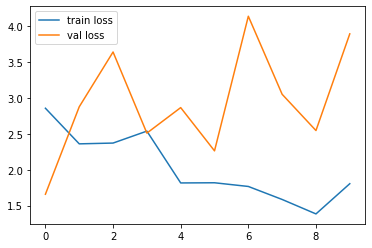

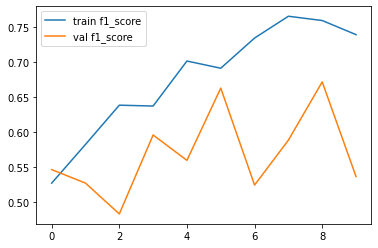

<Figure size 432x288 with 0 Axes>

In [28]:
# plot the loss
plt.plot(run.history['loss'], label='train loss')
plt.plot(run.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(run.history['f1_score'], label='train f1_score')
plt.plot(run.history['val_f1_score'], label='val f1_score')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

The diagrams show that the model suffered from overfitting on the training set. And the value of the f1 score oscillates between 0.5 and 0.65

The final f1_score (macro) of the validation set is **0.54**

## 5) Test Set predictions

In [45]:
test_pred = model.predict(test_generator)

40/40 [==============================] - 72s 2s/step


In [41]:
test_pred=np.argmax(test_pred,axis=1)

In [35]:
test_results=pd.DataFrame()
test_results.index=test.index
test_results['target']=test_pred

In [37]:
test_results

,target
0,2
1,2
2,0
3,2
4,2
...,...
630,2
631,1
632,2
633,0


In [52]:
results_json = test_results.to_json('predictions.json',orient = 'columns') 